In [1]:
%matplotlib inline

import os
import glob
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

plt.style.use("./paper.mplstyle")

In [2]:
depth_df_files = glob.glob("../results/sampling_depth/sim/*.tsv")
depth_regex = re.compile("../results/sampling_depth/sim/sim_counts.mean_depth_(\d+).tsv")

depth_df_files = sorted(depth_df_files, key=lambda x: int(depth_regex.search(x).groups()[0]))
depth_dict = dict()
for f in depth_df_files:
    mean_depth = depth_regex.search(f).groups()[0]
    _df = pd.read_table(f, index_col=0, sep="\t")
    _df["depth"] = np.exp(_df["log_depth"])
    depth_dict[mean_depth] = _df

In [3]:
concat_inf = xr.open_dataset("../results/sampling_depth/concat_posterior.nc")

In [4]:
concat_inf

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 500, mean_depth: 7, column: 2, tbl_sample: 500)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
  * column      (column) object 'Intercept' 'beta_case'
  * tbl_sample  (tbl_sample) object 'SA1' 'SA2' 'SA3' ... 'SB249' 'SB250'
  * mean_depth  (mean_depth) int64 50000 5000 10000 20000 100000 2000 1000
Data variables:
    beta_0      (mean_depth, chain, draw) float64 ...
    beta_1      (mean_depth, chain, draw) float64 ...
    inv_disp    (mean_depth, chain, draw) float64 ...
    beta_var    (mean_depth, chain, draw, column) float64 ...
    lam         (mean_depth, chain, draw, tbl_sample) float64 ...
Attributes:
    created_at:                 2022-07-20T16:05:22.839487
    arviz_version:              0.11.2
    inference_library:          cmdstanpy
    inference_library_version:  1.0.4

In [5]:
order = list(map(str, sorted(concat_inf.coords["mean_depth"].values)))
order

['1000', '2000', '5000', '10000', '20000', '50000', '100000']

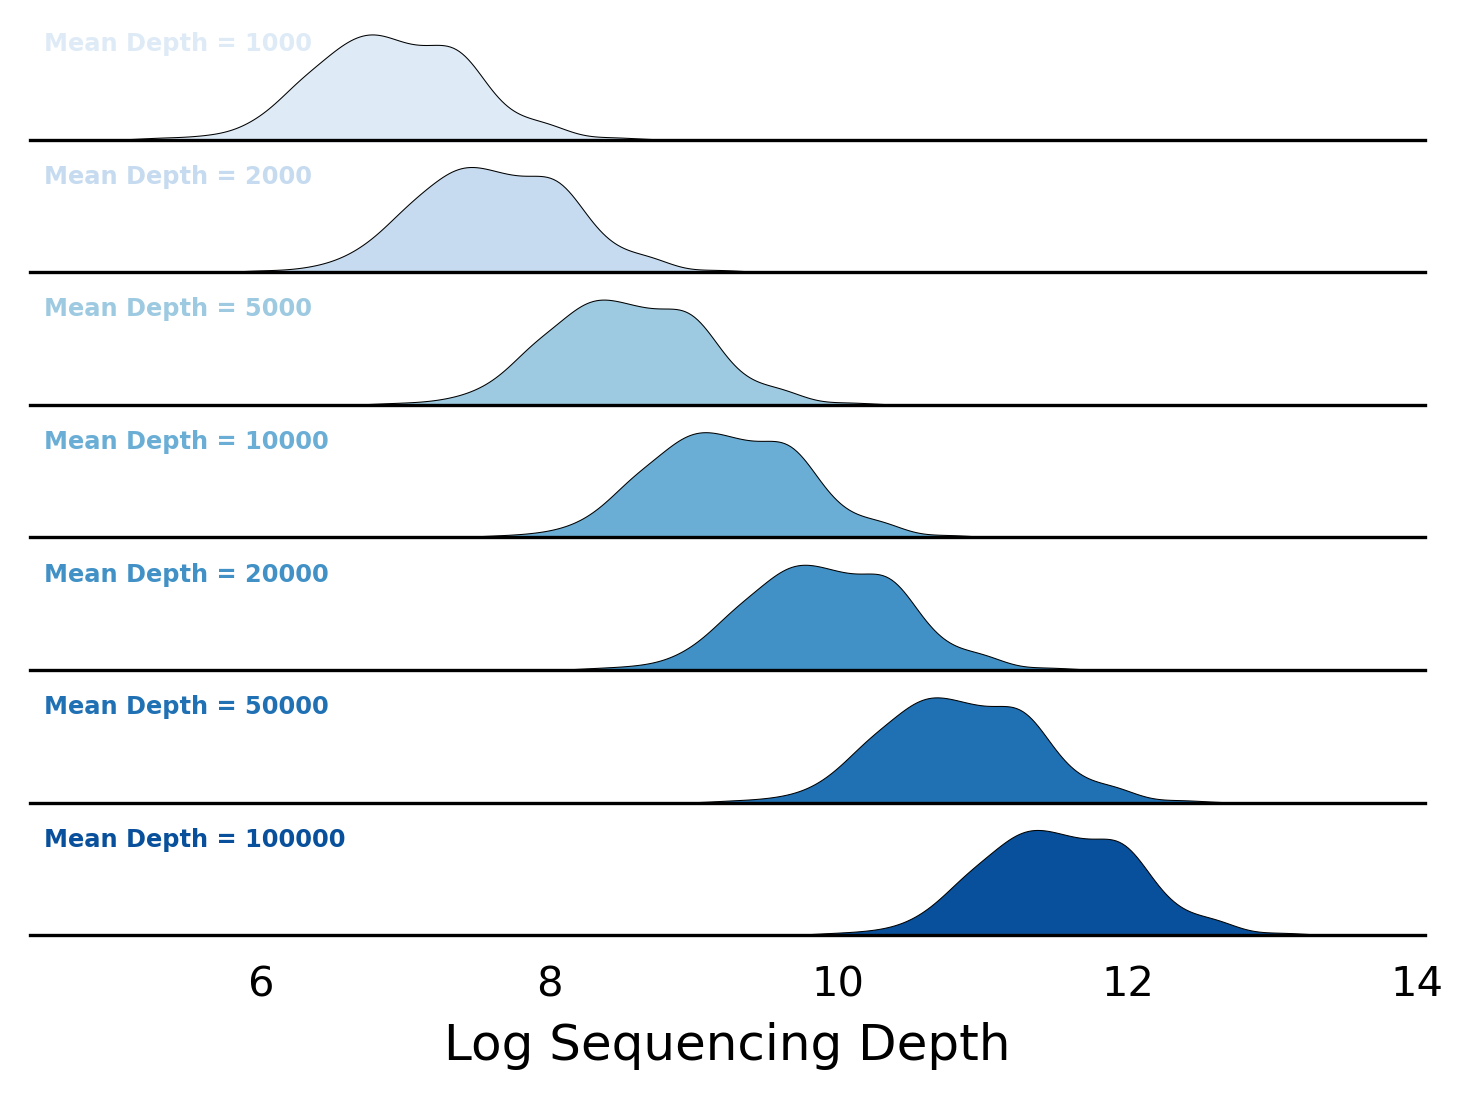

In [6]:
palette = dict(zip(
    order,
    sns.color_palette("Blues", len(order))
))

num_depths = len(depth_dict)

fig, axs = plt.subplots(num_depths, 1, sharex=True)

for ax, (depth, _df) in zip(axs, depth_dict.items()):
    ax.set_clip_on(False)
    sns.kdeplot(
        _df["log_depth"],
        ax=ax,
        color=palette[depth],
        fill=True,
        edgecolor="black",
        lw=0.25,
        alpha=1,
    )
    ax.spines["left"].set_visible(False)
    ax.yaxis.set_visible(False)
    ax.tick_params("x", width=0)
    
    ax.text(
        x=0.01,
        y=0.98,
        s=f"Mean Depth = {depth}",
        transform=ax.transAxes,
        fontsize="xx-small",
        color=palette[depth],
        fontweight="bold",
        ha="left",
        va="top"
    )

ax.set_xlabel("Log Sequencing Depth")

plt.savefig("../figures/simulation/sampling_depths_log.pdf")
plt.show()

In [7]:
beta_var_df = (
    concat_inf["beta_var"]
    .to_dataframe()
    .reset_index()
    .melt(id_vars=["mean_depth", "column"], value_vars=["beta_var"])
    .drop(columns=["variable"])
)
beta_var_df["mean_depth"] = beta_var_df["mean_depth"].astype(str)
beta_var_df["mean_depth"] = pd.Categorical(beta_var_df["mean_depth"], categories=order, ordered=True)
beta_var_df.head()

,mean_depth,column,value
0,50000,Intercept,-7.92241
1,50000,beta_case,2.83665
2,50000,Intercept,-7.38021
3,50000,beta_case,2.44102
4,50000,Intercept,-8.16529


In [8]:
inv_disp_df = (
    concat_inf["inv_disp"]
    .to_dataframe()
    .reset_index()
    .melt(id_vars=["mean_depth"], value_vars=["inv_disp"])
    .drop(columns=["variable"])
)
inv_disp_df["mean_depth"] = inv_disp_df["mean_depth"].astype(str)
inv_disp_df["mean_depth"] = pd.Categorical(inv_disp_df["mean_depth"], categories=order, ordered=True)
inv_disp_df.head()

,mean_depth,value
0,50000,11.29260
1,50000,9.23228
2,50000,11.23230
3,50000,11.02020
4,50000,9.01099


In [9]:
beta_var_df.groupby(["column", "mean_depth"]).mean()

value
column    mean_depth          
Intercept 1000       -7.847702
          2000       -7.784125
          5000       -7.776420
          10000      -7.671838
          20000      -7.844575
          50000      -7.758240
          100000     -7.822153
beta_case 1000        2.964319
          2000        2.893556
          5000        3.005770
          10000       2.662263
          20000       3.074028
          50000       3.006919
          100000      2.910422

In [10]:
beta_var_df

,mean_depth,column,value
0,50000,Intercept,-7.92241
1,50000,beta_case,2.83665
2,50000,Intercept,-7.38021
3,50000,beta_case,2.44102
4,50000,Intercept,-8.16529
...,...,...,...
27995,1000,beta_case,3.37648
27996,1000,Intercept,-7.43871
27997,1000,beta_case,2.59734
27998,1000,Intercept,-8.16955


In [11]:
inv_disp_df.groupby(["mean_depth"]).var()

,value
mean_depth,
1000,0.871500
2000,0.703622
5000,0.852391
10000,0.699679
20000,0.642124
50000,0.505439
100000,0.484280


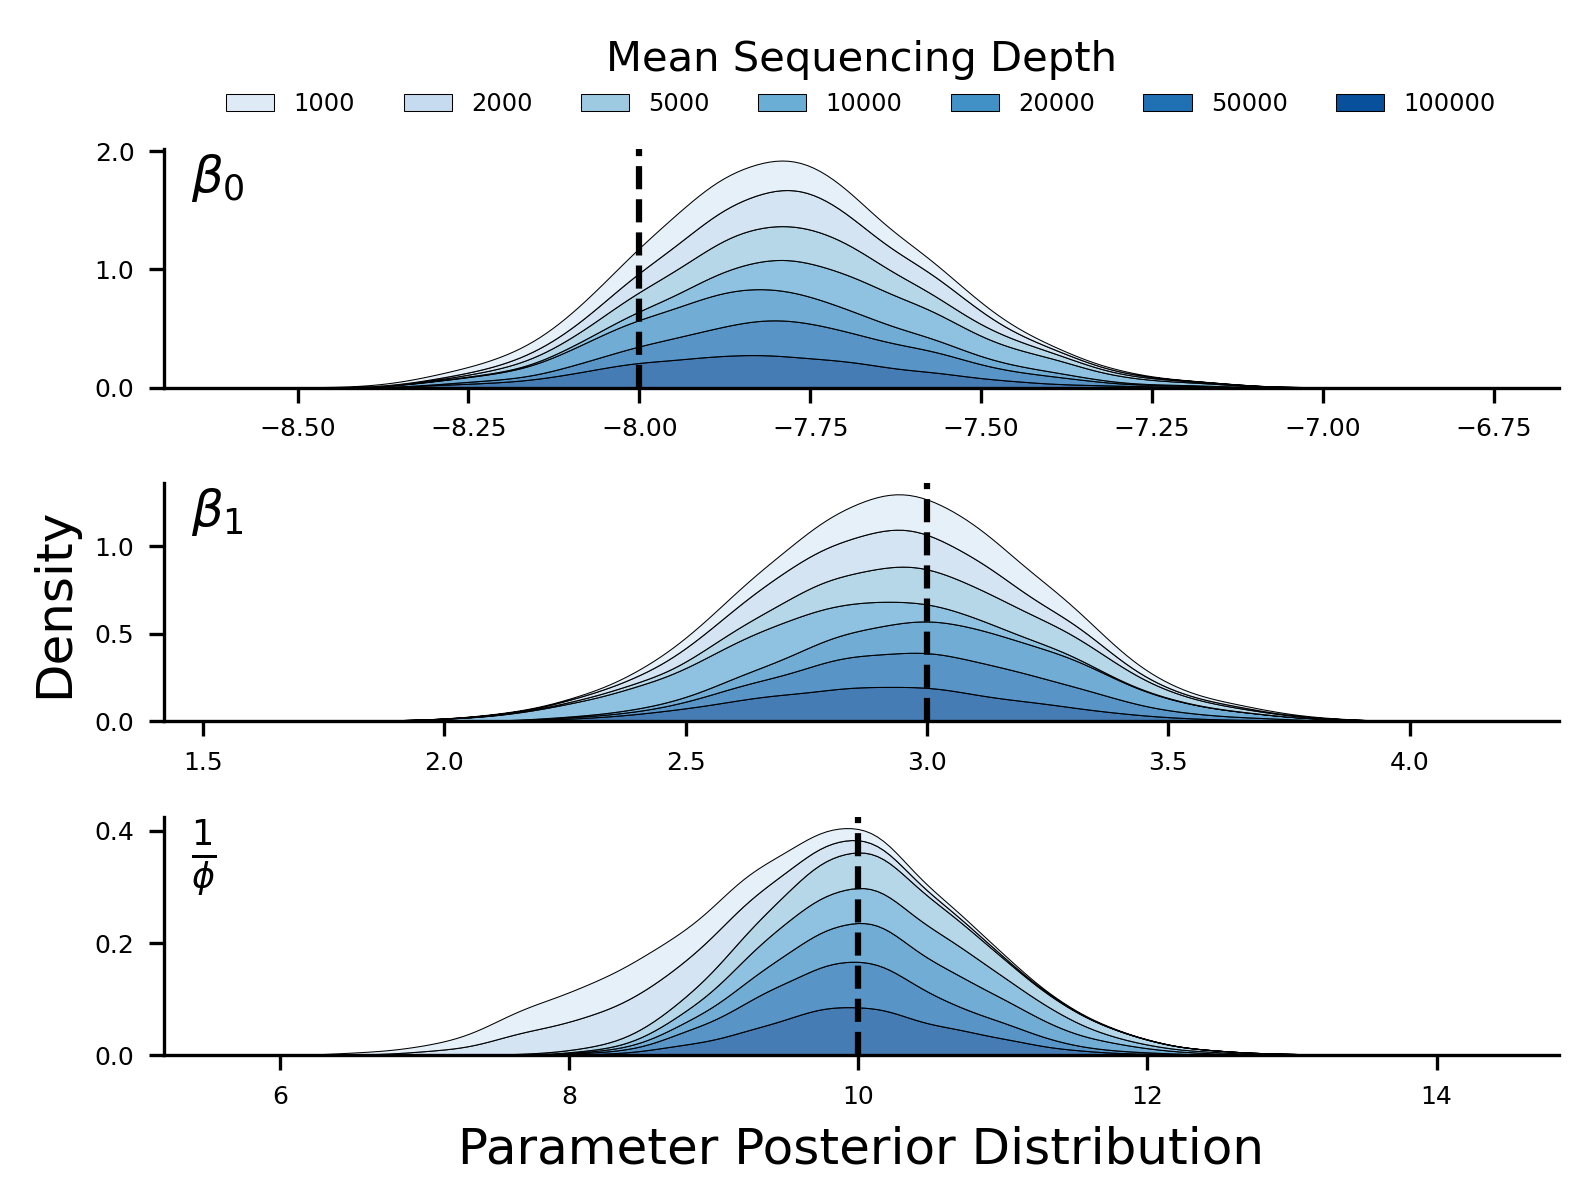

In [12]:
# import matplotlib.ticker as ticker
# from matplotlib.patches import Patch

# fig, axs = plt.subplots(3, 1)
# plt.subplots_adjust(hspace=0.4)
# coef_dict = {"Intercept": r"$\beta_0$", "beta_case": r"$\beta_1$"}
# palette = dict(zip(
#     order,
#     sns.color_palette("Blues", len(order))
# ))

# true_vals = [-8, 3]

# kde_args = {"x": "value", "hue": "mean_depth", "multiple": "stack", "palette": palette,
#             "linewidth": 0.25, "edgecolor": "black", "legend": False}
# txt_args = {"x": 0.02, "y": 0.99, "va": "top", "ha": "left", "size": "large"}
# for (col, _df), ax, true_val in zip(beta_var_df.groupby("column"), axs, true_vals):
#     sns.kdeplot(
#         data=_df,
#         ax=ax,
#         **kde_args
#     )
#     ax.axvline(true_val, color="black", ls="--")
#     ax.set_xlabel("")
#     ax.text(
#         s=coef_dict[col],
#         transform=ax.transAxes,
#         **txt_args
#     )
#     ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
    
# sns.kdeplot(
#     data=inv_disp_df,
#     ax=axs[2],
#     **kde_args,
# )
# axs[2].axvline(10, ls="--", color="black")

# axs[2].text(
#     s=r"$\frac{1}{\phi}$",
#     transform=axs[2].transAxes,
#     **txt_args
# )

# for ax in axs:
#     ax.tick_params("both", labelsize=6)
#     ax.set_ylabel("")

# axs[1].set_ylabel("Density")
# axs[2].set_xlabel("Parameter Posterior Distribution")

# patches = []
# for mean_depth, color in palette.items():
#     patch = Patch(facecolor=color, edgecolor="black", label=mean_depth, lw=kde_args["linewidth"])
#     patches.append(patch)

# axs[0].legend(
#     handles=patches,
#     frameon=False,
#     fontsize="xx-small",
#     ncol=7,
#     bbox_to_anchor=[0.5, 1.05],
#     loc="lower center",
#     title="Mean Sequencing Depth"
# )
    
# plt.savefig("../figures/simulation/sampling_depths_uncertainty.pdf")
# plt.show()

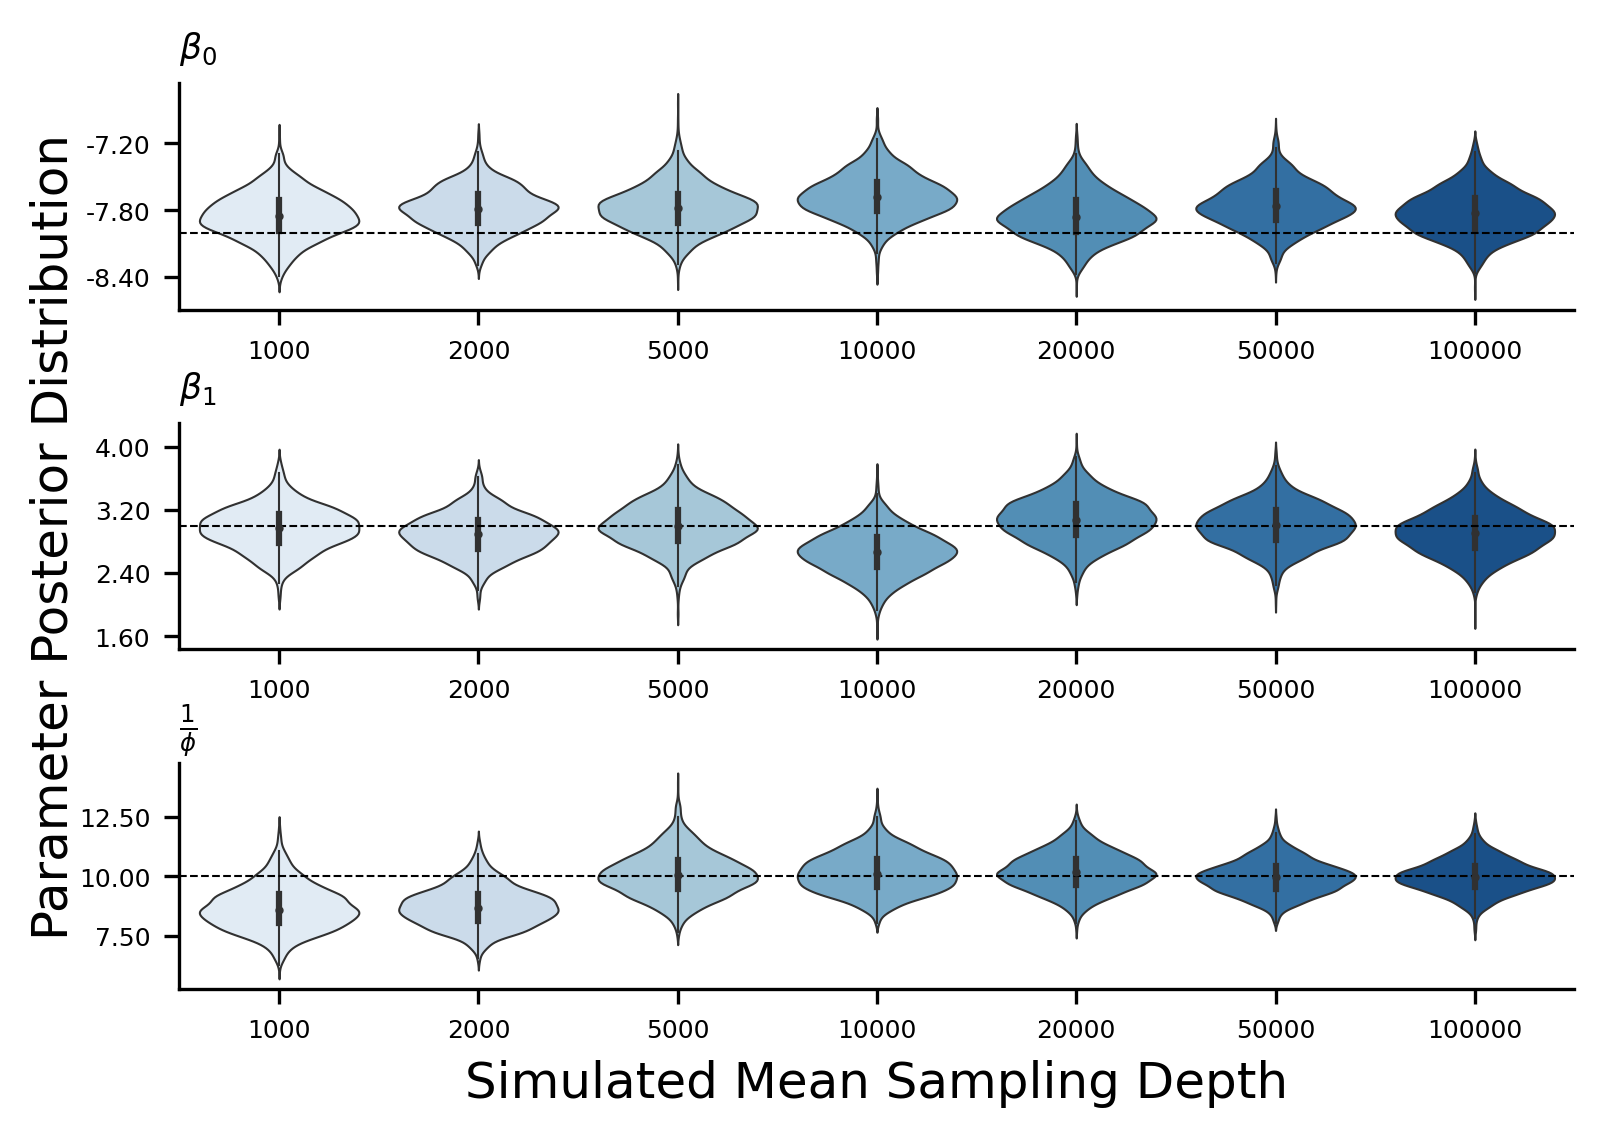

In [26]:
import matplotlib.ticker as ticker
from matplotlib.patches import Patch

fig, axs = plt.subplots(3, 1)
plt.subplots_adjust(hspace=0.5)
coef_dict = {"Intercept": r"$\beta_0$", "beta_case": r"$\beta_1$"}
palette = dict(zip(
    order,
    sns.color_palette("Blues", len(order))
))

true_vals = [-8, 3]

violin_args = {
    "x": "mean_depth",
    "y": "value",
    "palette": palette,
    "linewidth": 0.5, 
    "scale": "width"
}
for (col, _df), ax, true_val in zip(beta_var_df.groupby("column"), axs, true_vals):
    sns.violinplot(
        data=_df,
        ax=ax,
        **violin_args,
    )
    ax.axhline(true_val, color="black", ls="--", lw=0.5)
    ax.set_xlabel("")
    ax.set_title(coef_dict[col], fontsize="small")
    
sns.violinplot(
    data=inv_disp_df,
    ax=axs[2],
    **violin_args,
)
axs[2].axhline(10, ls="--", color="black", lw=0.5)

axs[2].set_title(r"$\frac{1}{\phi}$", fontsize="small")

for ax in axs:
    ax.tick_params("both", labelsize=6)
    ax.set_ylabel("")

axs[1].set_ylabel("Parameter Posterior Distribution")
axs[2].set_xlabel("Simulated Mean Sampling Depth")

for ax in axs:
    ax.yaxis.set_major_locator(ticker.MaxNLocator(4))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    
# plt.savefig("../figures/simulation/sampling_depths_uncertainty.pdf")
plt.show()